## Loading the necessary packages ##

In [71]:
import importlib
import subprocess
import sys

def install_and_import(package, import_name=None):
    """
    Try to import a package. If it's not installed, install it via pip and import again.
    package: name on pip (e.g. 'pandas')
    import_name: name used in import (e.g. 'pandas' or 'matplotlib.pyplot').
                 If None, uses package.
    """
    if import_name is None:
        import_name = package

    try:
        return importlib.import_module(import_name)
    except ImportError:
        print(f"{import_name} not found, installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return importlib.import_module(import_name)

# use it for your libs
pd = install_and_import("pandas")
np = install_and_import("numpy")
plt = install_and_import("matplotlib.pyplot", "matplotlib.pyplot")
math = install_and_import("math")

sklearn_model_selection = install_and_import("sklearn.model_selection", "sklearn.model_selection")
sklearn_preprocessing = install_and_import("sklearn.preprocessing", "sklearn.preprocessing")
sklearn_linear_model = install_and_import("sklearn.linear_model", "sklearn.linear_model")
sklearn_metrics = install_and_import("sklearn.metrics", "sklearn.metrics")


from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error

## Loading the data ##

In [72]:
filtered_data_anal = pd.read_csv("./filtered_data_anal.csv")
filtered_data_anal.head() # loading the data
print(filtered_data_anal.info())

target_col = "math_score_8_std"   # specifying the dependent variable

y = filtered_data_anal[target_col]

# X: all other variables except the target
X = filtered_data_anal.drop(columns=[target_col])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50931 entries, 0 to 50930
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   site_id_(telephely)           50931 non-null  int64  
 1   class_size                    50931 non-null  int64  
 2   teachers_number_site          50931 non-null  float64
 3   math_score_8_std              50931 non-null  float64
 4   total_students_site           50931 non-null  int64  
 5   mother_education_level        50931 non-null  object 
 6   father_education_level        50931 non-null  object 
 7   books_at_home                 50931 non-null  object 
 8   family_background_index_std   50931 non-null  float64
 9   student_gender                50931 non-null  object 
 10  class_curriculum_type         50931 non-null  object 
 11  multiplied_disadvantaged      50931 non-null  object 
 12  county_code_school            50931 non-null  int64  
 13  s

## Looking at the data a bit ##

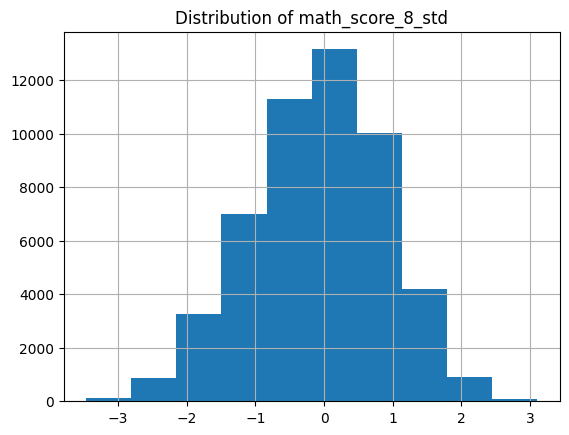

In [73]:
plt.figure()
y.hist()
plt.title("Distribution of math_score_8_std") # standard normal distribution due to the fact that we 
plt.show()

## Handling missing values and select numeric features ##

In [74]:
num_cols = X.select_dtypes(include=["number"]).columns.tolist() # selecting the numerical columnes
cat_cols = [c for c in X.columns if c not in num_cols] # selecting the categorical columns

print("Numeric columns:", len(num_cols))
print("Categorical columns (ignored later):", len(cat_cols))

# Numeric features: fill missing values with column mean --> Not possible, just in case (won't be any missing due to filtering)
#if num_cols:
    #X[num_cols] = X[num_cols].fillna(X[num_cols].mean(numeric_only=True))

# Categorical features: only to remove NaNs (we will not use them later)
#if cat_cols:
    #X[cat_cols] = X[cat_cols].fillna("missing")

print("Remaining NaNs (should be 0):", int(X.isna().sum().sum()))

# From here on, we use numeric-only features
X_num = X[num_cols].copy()
print("X_num shape:", X_num.shape)

Numeric columns: 6
Categorical columns (ignored later): 8
Remaining NaNs (should be 0): 0
X_num shape: (50931, 6)


In [75]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X_num, y, test_size=0.2, random_state=76678
)

# y does not need to be scaled because it is stnadardized

# Standardize features
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

print("Shapes — original:", X_tr.shape,
      "| scaled:", X_tr_s.shape)

Shapes — original: (40744, 6) | scaled: (40744, 6)


In [76]:
lin = LinearRegression().fit(X_tr_s, y_tr)
y_lin = lin.predict(X_te_s)

print(f"LinearRegression — Test R^2: {r2_score(y_te, y_lin):.3f} | "
      f"RMSE: {np.sqrt(mean_squared_error(y_te, y_lin)):.3f}")

LinearRegression — Test R^2: 0.258 | RMSE: 0.842


## Ridge regression ##

Best lambda by 5-fold CV (min RMSE): 1000.0
Test R^2 score for RidgeCV model: 0.2578813666104416
Test RMSE score for RidgeCV model: 0.8422938663030359


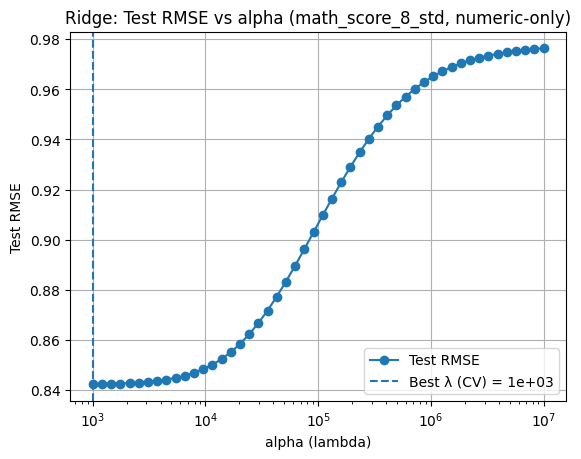

In [91]:
# Grid of lambda (alpha) values
lambda_ridge = np.logspace(3, 7, 50)

# 1) Choose best alpha by 5-fold CV on the TRAIN set,
#    minimizing MSE (equivalent to minimizing RMSE)
ridge_cv = RidgeCV(
    alphas=lambda_ridge,
    cv=5,
    scoring="neg_mean_squared_error"  # higher = better, since it's NEGATIVE MSE
)
ridge_cv.fit(X_tr_s, y_tr)

best_lambda = ridge_cv.alpha_
print("Best lambda by 5-fold CV (min RMSE):", best_lambda)

# 2) Evaluate this best model on the TEST set
y_hat_test = ridge_cv.predict(X_te_s)

R2_test = r2_score(y_te, y_hat_test)
RMSE_test = sqrt(mean_squared_error(y_te, y_hat_test))

print("Test R^2 score for RidgeCV model:", R2_test)
print("Test RMSE score for RidgeCV model:", RMSE_test)

# 3) For plotting: compute TEST RMSE for each alpha using plain Ridge
rows = []
for l in lambda_ridge:
    ridge = Ridge(alpha=l)
    ridge.fit(X_tr_s, y_tr)
    y_hat = ridge.predict(X_te_s)
    rows.append({
        "alpha": l,
        "R2_test": r2_score(y_te, y_hat),
        "RMSE_test": sqrt(mean_squared_error(y_te, y_hat))
    })

res_ridge = pd.DataFrame(rows)

# 4) Plot test RMSE vs alpha, and mark the CV-chosen alpha
plt.figure()
plt.semilogx(res_ridge["alpha"], res_ridge["RMSE_test"], marker="o", label="Test RMSE")
plt.axvline(best_lambda, linestyle="--", label=f"Best λ (CV) = {best_lambda:.2g}")
plt.xlabel("alpha (lambda)")
plt.ylabel("Test RMSE")
plt.title("Ridge: Test RMSE vs alpha (math_score_8_std, numeric-only)")
plt.legend()
plt.grid(True)
plt.show()


## Lasso regression ##

Best lambda by 5-fold CV (min RMSE, Lasso): 2.811768697974231e-06
Test R^2 score for LassoCV model: 0.25839441175761435
Test RMSE score for LassoCV model: 0.8420026665720406


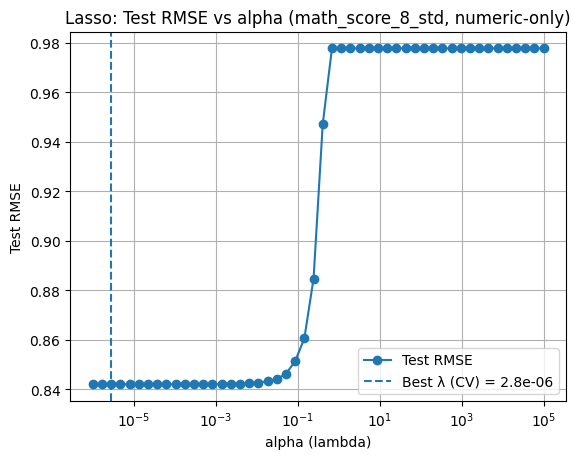

In [92]:
# Grid of lambda (alpha) values
lambda_lasso = np.logspace(-6, 5, 50)

# 1) Choose best alpha by 5-fold CV on the TRAIN set,
#    minimizing MSE (equivalent to minimizing RMSE)
lasso_cv = LassoCV(
    alphas=lambda_lasso,
    cv=5,
    max_iter=1000,
    tol=1e-5,
    random_state=42
)
lasso_cv.fit(X_tr_s, y_tr)

best_lambda_lasso = lasso_cv.alpha_
print("Best lambda by 5-fold CV (min RMSE, Lasso):", best_lambda_lasso)

# 2) Evaluate this best model on the TEST set
y_hat_test_lasso = lasso_cv.predict(X_te_s)

R2_test_lasso = r2_score(y_te, y_hat_test_lasso)
RMSE_test_lasso = sqrt(mean_squared_error(y_te, y_hat_test_lasso))

print("Test R^2 score for LassoCV model:", R2_test_lasso)
print("Test RMSE score for LassoCV model:", RMSE_test_lasso)

# 3) For plotting: compute TEST RMSE for each alpha using plain Lasso
rows = []
for l in lambda_lasso:
    lasso = Lasso(alpha=l, max_iter=1000, tol=1e-5)
    lasso.fit(X_tr_s, y_tr)
    y_hat = lasso.predict(X_te_s)
    rows.append({
        "alpha": l,
        "R2_test": r2_score(y_te, y_hat),
        "RMSE_test": sqrt(mean_squared_error(y_te, y_hat))
    })

res_lasso = pd.DataFrame(rows)

# 4) Plot test RMSE vs alpha, and mark the CV-chosen alpha
plt.figure()
plt.semilogx(res_lasso["alpha"], res_lasso["RMSE_test"], marker="o", label="Test RMSE")
plt.axvline(best_lambda_lasso, linestyle="--", label=f"Best λ (CV) = {best_lambda_lasso:.2g}")
plt.xlabel("alpha (lambda)")
plt.ylabel("Test RMSE")
plt.title("Lasso: Test RMSE vs alpha (math_score_8_std, numeric-only)")
plt.legend()
plt.grid(True)
plt.show()


Best lambda by 5-fold CV (min RMSE, Lasso): 0.01
Test R^2 score for LassoCV model: 0.25727605178823265
Test RMSE score for LassoCV model: 0.8426373080487298


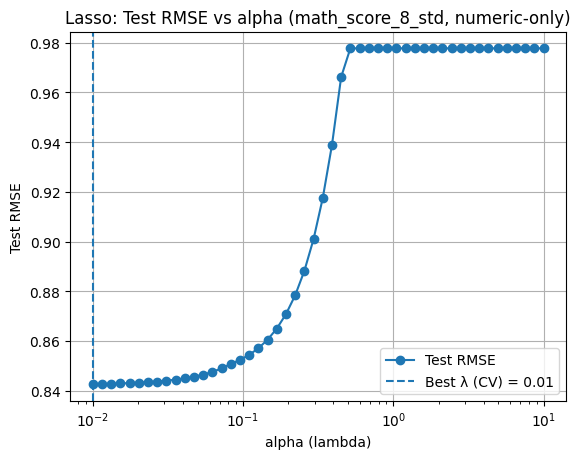

In [93]:
# Grid of lambda (alpha) values
lambda_lasso = np.logspace(-2, 1, 50)

# 1) Choose best alpha by 5-fold CV on the TRAIN set,
#    minimizing MSE (equivalent to minimizing RMSE)
lasso_cv = LassoCV(
    alphas=lambda_lasso,
    cv=5,
    max_iter=1000,
    tol=1e-5,
    random_state=42
)
lasso_cv.fit(X_tr_s, y_tr)

best_lambda_lasso = lasso_cv.alpha_
print("Best lambda by 5-fold CV (min RMSE, Lasso):", best_lambda_lasso)

# 2) Evaluate this best model on the TEST set
y_hat_test_lasso = lasso_cv.predict(X_te_s)

R2_test_lasso = r2_score(y_te, y_hat_test_lasso)
RMSE_test_lasso = sqrt(mean_squared_error(y_te, y_hat_test_lasso))

print("Test R^2 score for LassoCV model:", R2_test_lasso)
print("Test RMSE score for LassoCV model:", RMSE_test_lasso)

# 3) For plotting: compute TEST RMSE for each alpha using plain Lasso
rows = []
for l in lambda_lasso:
    lasso = Lasso(alpha=l, max_iter=1000, tol=1e-5)
    lasso.fit(X_tr_s, y_tr)
    y_hat = lasso.predict(X_te_s)
    rows.append({
        "alpha": l,
        "R2_test": r2_score(y_te, y_hat),
        "RMSE_test": sqrt(mean_squared_error(y_te, y_hat))
    })

res_lasso = pd.DataFrame(rows)

# 4) Plot test RMSE vs alpha, and mark the CV-chosen alpha
plt.figure()
plt.semilogx(res_lasso["alpha"], res_lasso["RMSE_test"], marker="o", label="Test RMSE")
plt.axvline(best_lambda_lasso, linestyle="--", label=f"Best λ (CV) = {best_lambda_lasso:.2g}")
plt.xlabel("alpha (lambda)")
plt.ylabel("Test RMSE")
plt.title("Lasso: Test RMSE vs alpha (math_score_8_std, numeric-only)")
plt.legend()
plt.grid(True)
plt.show()
